In [ ]:
import requests

MESONET_URL = 'https://api.nysmesonet.org/data/dynserv/timeseries2'

payload = {
    'dataset':'nysm',
    'stations':['DUAN'],
    'variables':['precip'],
    'start': "20201220T0700",
    'end': "20201223T1819"
}

r = requests.post(MESONET_URL, json=payload)

print(r.text)


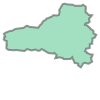

In [1]:
import requests
import json
import rasterio
from rasterio.plot import show
import rasterio.mask
import pyflwdir


import pyproj
from shapely.ops import transform
from shapely.geometry import shape, Point, GeometryCollection

x,y = -73.72435569763185, 43.17261895666325

NLDI_GEOSERVER_URL = 'https://labs.waterdata.usgs.gov/geoserver/wmadata/ows'


wkt_point = "POINT(%f %f)" %  (x , y)
cql_filter = "INTERSECTS(the_geom, %s)" % (wkt_point)

payload = {
    'service': 'wfs', 
    'version': '1.0.0', 
    'request': 'GetFeature', 
    'typeName': 'wmadata:catchmentsp', 
    'outputFormat': 'application/json',
    'srsName': 'EPSG:4326',
    'CQL_FILTER': cql_filter
}

#request catchment geometry from point in polygon query from NLDI geoserver
# https://labs.waterdata.usgs.gov/geoserver/wmadata/ows?service=wfs&version=1.0.0&request=GetFeature&typeName=wmadata%3Acatchmentsp&outputFormat=application%2Fjson&srsName=EPSG%3A4326&CQL_FILTER=INTERSECTS%28the_geom%2C+POINT%28-73.745860+44.006830%29%29
r = requests.get(NLDI_GEOSERVER_URL, params=payload)
resp = r.json()

#get catchment id
catchmentIdentifier = json.dumps(resp['features'][0]['properties']['featureid'])

#get main catchment geometry polygon
features = resp['features']
catchmentGeom = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

catchmentGeom

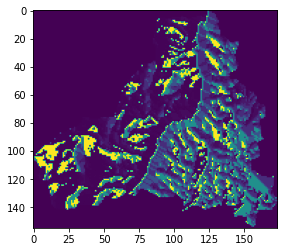

<AxesSubplot:>

In [2]:
#clip raster
with rasterio.open('/vsicurl/https://prod-is-usgs-sb-prod-publish.s3.amazonaws.com/5fe0d98dd34e30b9123eedb0/fdr.tif', 'r') as ds:
    dest_crs = ds.crs
    wgs84 = pyproj.CRS('EPSG:4326')
    latlon = dest_crs == wgs84
    
    project_to_raster = pyproj.Transformer.from_crs(wgs84, dest_crs, always_xy=True).transform
    project_to_wgs84 = pyproj.Transformer.from_crs(dest_crs, wgs84, always_xy=True).transform
    projected_catchment_geom = transform(project_to_raster, catchmentGeom)

    flwdir, flwdir_transform = rasterio.mask.mask(ds, projected_catchment_geom, crop=True)
    
flw = pyflwdir.from_array(flwdir[0], ftype='d8', transform=flwdir_transform, latlon=latlon)

# print(flw)

show(flwdir)

In [ ]:
import numpy as np
from shapely.geometry import shape, Point, Polygon
import json

point_geom = Point(x,y)

print(json.dumps(shapely.geometry.mapping(point_geom)))

print('original point:',point_geom)

projected_point = transform(project_to_raster, point_geom)

print('projected point:',projected_point)

xy = projected_point.coords[:][0]

stream_order = flw.stream_order()

# delineate subbasins
subbasins = flw.basins(xy=xy, streams=stream_order>4)

#convert subbasins from uint32
subbasins = subbasins.astype(np.int16)
show(subbasins)

#convert raster to features
mask = subbasins != 0
polys = rasterio.features.shapes(subbasins, transform=flwdir_transform, mask=mask)

#just get one we want [not sure why we need to grab this]
poly = next(polys)



d = 0.00045 # distance
cf = 1.3  # cofactor

#project back to wgs84
split_geom = transform(project_to_wgs84, shape(poly[0])).simplify(d)



diff = catchment_geom.difference(split_geom).buffer(-d).buffer(d*cf).simplify(d)


json.dumps(shapely.geometry.mapping(diff ))



In [ ]:
NLDI_URL = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/comid/'

#request upstream basin
payload = {'f': 'json', 'simplified': 'false'}

#request upstream basin from NLDI using comid of catchment point is in
r = requests.get(NLDI_URL + catchmentIdentifier + '/basin', params=payload)

#print('upstream basin', r.text)
resp = r.json()

#get main catchment geometry polygon
features = resp['features']
upstream_geom = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

final = upstream_geom.difference(diff).buffer(-d).buffer(d*cf).simplify(d)


json.dumps(shapely.geometry.mapping(final))